# **Graph Network**

The objective, in this notebook, is to create a graph network of the 155 labeled regions from the previous work.

The graph network we have to build will represent the regions sharing the same road segments.

#**Setting up the notebook:**

Installing Google Drive to save the main milestones.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#Libraries needed in this notebook
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import numpy as np

We start from the result of the notebook "Segmentation". Here, we label each region of Chicago delimited by road segments and identified with a region ID.

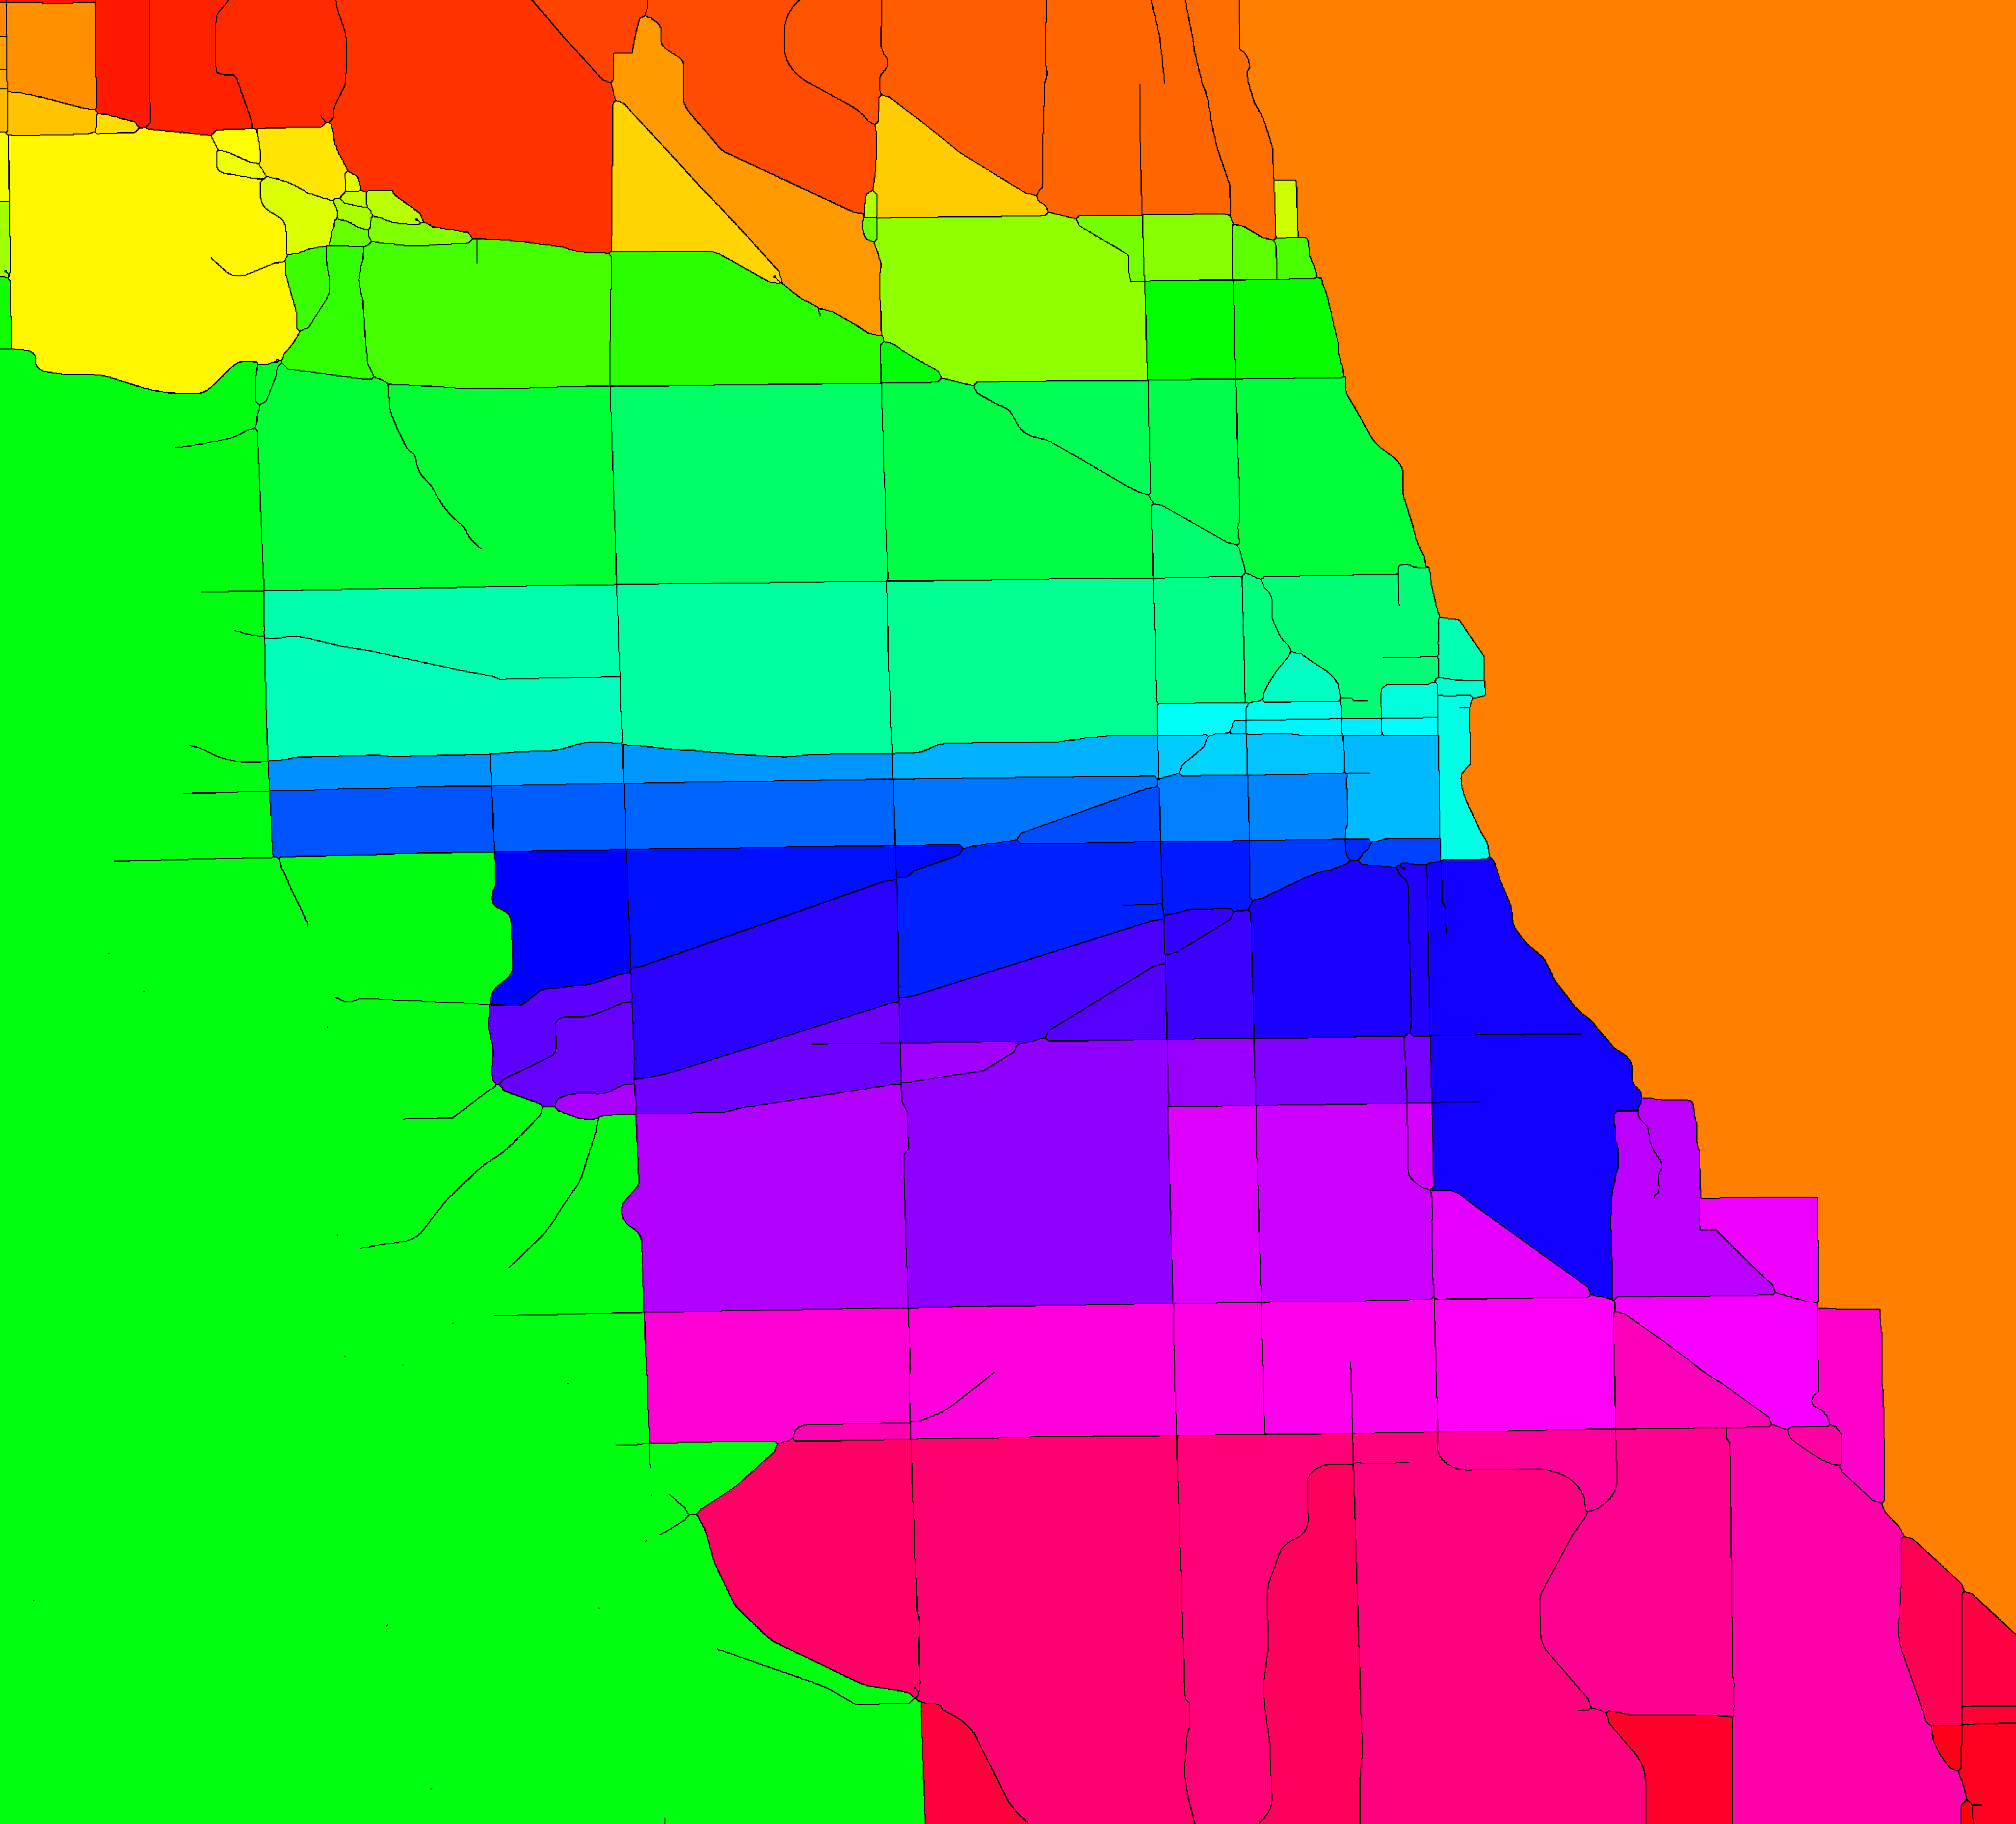

In [ ]:
img = cv2.imread('/content/chicago_road_network_thinned_inverted_2.png', 0)
img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary
num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(img)

def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    from google.colab.patches import cv2_imshow
    cv2_imshow(labeled_img)
    cv2.imwrite('chicago_labeled.png',labeled_img) 

imshow_components(labels_im)

# **Building the graph**

We explore the content, shape, values of results returned previously.

In [ ]:
print(labels_im)
print("dimensions (col x row) :", labels_im.shape)

[[  1   1   1 ...  13  13  13]
 [  1   1   1 ...  13  13  13]
 [  1   1   1 ...  13  13  13]
 ...
 [ 54  54  54 ... 152 152 152]
 [ 54  54  54 ... 152 152 152]
 [ 54  54  54 ... 152 152 152]]
dimensions (col x row) : (3716, 4108)


In [ ]:
print("Number of different regions and IDs ", num_labels)

Number of different regions and IDs  155


In [ ]:
#print(centroids)
print(centroids.shape)

(155, 2)


In [ ]:
print(stats)
print(stats.shape)

# **Creating the function to build the graph for a local view**

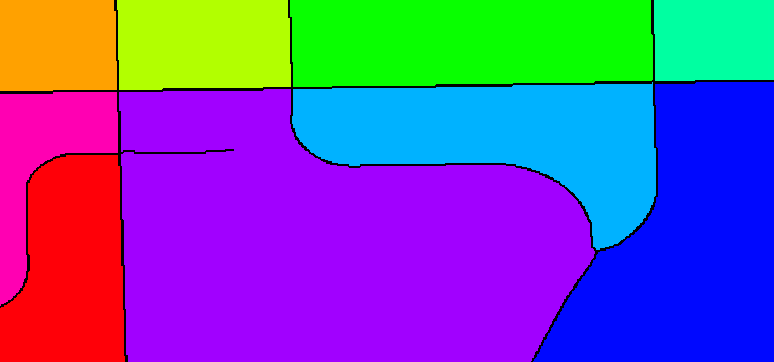

In [ ]:
img = cv2.imread('/content/chicago_road_network_thinned_inverted_local.png', 0)
img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]  # ensure binary
num_labels, labels_im, stats, centroids = cv2.connectedComponentsWithStats(img)

def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    cv2_imshow(labeled_img)
    cv2.imwrite('chicago_local_labeled.png',labeled_img) 

imshow_components(labels_im)

In [ ]:
print("Number of region IDs :", num_labels)
print("Label matrix shape (row x col): ", labels_im.shape)
print("Label matrix ", labels_im)

Number of region IDs : 10
Label matrix shape (row x col):  (362, 774)
Label matrix  [[1 1 1 ... 4 4 4]
 [1 1 1 ... 4 4 4]
 [1 1 1 ... 4 4 4]
 ...
 [9 9 9 ... 6 6 6]
 [9 9 9 ... 6 6 6]
 [9 9 9 ... 6 6 6]]


**Creating the functions to write text on image**

In [ ]:
def writeTextsOnImage(imagePath, textCoordinatesArray, textColor, saveImage = False, labeledImagePath = None):
  image = cv2.imread(imagePath) 
  font = cv2.FONT_HERSHEY_SIMPLEX 
  color = textColor
  fontScale = 1
  thickness = 2
  for textElement in textCoordinatesArray:
    textStr = textElement[0]
    coordinatesTuple = textElement[1]
    image = cv2.putText(image, textStr, coordinatesTuple, font,  
                   fontScale, color, thickness, cv2.LINE_AA) 
  
  if saveImage and labeledImagePath:
    cv2.imwrite(labeledImagePath,image)
  
  cv2_imshow( image)

def buildTextCoordinatesArray(centroidsArray):
  textCoordinatesArray = []
  n = len(centroidsArray)
  i = 1
  while i < n:
    x = np.int64(centroidsArray[i][0])
    y = np.int64(centroidsArray[i][1])
    CoordTuple = tuple((x, y))
    textStr = str(i)
    textCoordinatesArray.append([textStr, CoordTuple])
    i = i + 1
  return textCoordinatesArray

The algorithm below finds all the corners on a picture, depending on various parameters. The idea is to compute the gradient at a given pixel. When the gradient has various values in different directions, that means it's a corner separating two or more objects.

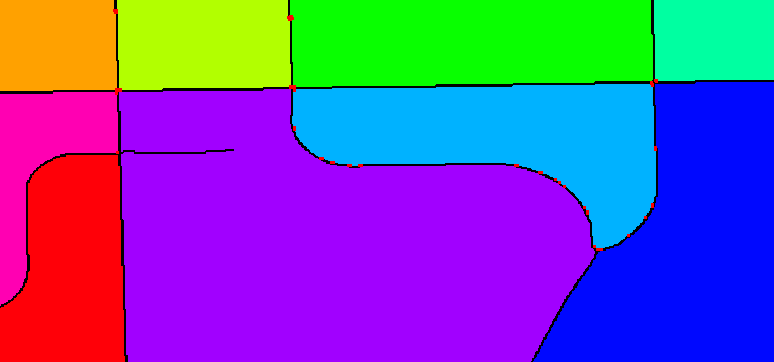

In [ ]:
filename = '/content/chicago_local_labeled.png'
img = cv2.imread(filename)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.08)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.05*dst.max()]=[0,0,255]
cv2_imshow( img)

We look at the array returned by cornerHarris algorithm.



In [ ]:
n, m = dst.shape
print(n, m)
print(dst)

362 774
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Since we want to get the position [x, y] of each corner, we build a function that loop through the array dst returned by the cornerHarris algorithm.

In [ ]:
def return_corners_coord(cornerHarrisDst, thresholdMult = 0.05):
  n, m = cornerHarrisDst.shape
  threshold = thresholdMult*cornerHarrisDst.max()
  i = 0
  corners_coord = []
  while i < n:
    j = 0
    while j < m:
      if cornerHarrisDst[i][j] > threshold:
        corners_coord.append([i,j])
      j = j + 1
    i = i + 1
  return corners_coord

We verify everything is correct by changing the corner color to white (color not existing on the original image).

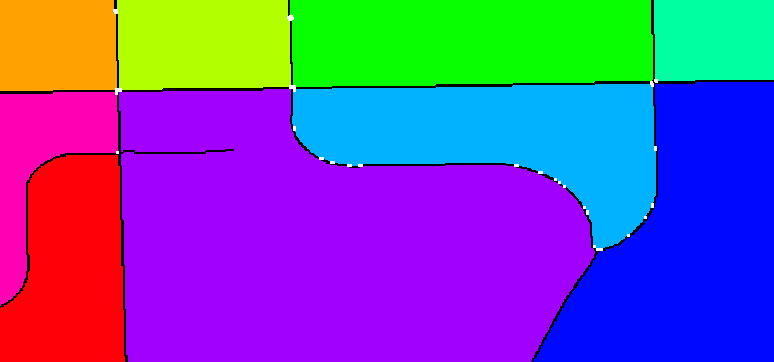

In [ ]:
corners_coord = return_corners_coord(dst)

for corner_coor in corners_coord:
  img[corner_coor[0], corner_coor[1]]=[255,255,255]
cv2_imshow(img)

To build the graph network, we need more than the list of corners we got so far. Below, we implement one natural solution. At each corner, we compute a "perimeter". From there, we extract the region IDs from the array containing the labels. All the region IDs inside the perimeter are separated by the same road segment and thus are connected.

We define a radius of 8 pixels for the perimeter and check if it is sufficient on the local view.

In [ ]:
def mark_local_range(corners_array, baseImage):
  n = baseImage.shape[0]
  m = baseImage.shape[1]
  radius = 8
  colormark1 = [0, 0, 0]
  colormark2 = [255, 0, 0]
  colormark3 = [0, 255, 0]
  colormark4 = [0, 0, 255]

  for corner_coor in corners_array:
    x1 = max(corners_array[0] - radius, 0)
    x2 = min(corners_array[0] + radius, n-1)
    y1 = max(corners_array[1] - radius, 0)
    y2 = min(corners_array[1] + radius, m-1)

    baseImage[x1, corners_array[1]] = colormark1
    baseImage[x1, y2] = colormark1
    baseImage[x2, corners_array[1]] = colormark2
    baseImage[x2, y1] = colormark2
    baseImage[corners_array[0], y1] = colormark3
    baseImage[x1, y1] = colormark3
    baseImage[corners_array[0], y2] = colormark4
    baseImage[x2, y2] = colormark4

  cv2_imshow(baseImage)

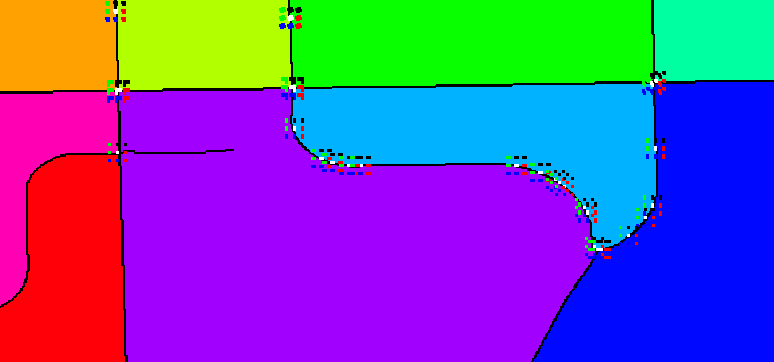

In [ ]:
baseImageCopy = img.copy()
mark_local_range(corners_coord, baseImageCopy)

Now, we can loop through the corner coordinates array in order to get all the regions connected to each other, meaning they share the same road segments.

The graph matrix will be a square matrix with size equal to the number of labels minus 1 for road segment. The matrix is symmetric. Its value at position [i, j] will be:
1. 1 if regions i and j share the same road segment
2. 0 otherwise

Since a region is connected to itself, the graph matrix has value 1 on its diagonal. 

In [ ]:
def return_graph_matrix(labelsArray, cornersArray, radius = 8):
  graph_matrix = np.identity(num_labels-1)
  n = labelsArray.shape[0]
  m = labelsArray.shape[1]
  for corner_coor in cornersArray:
    regionIDsList = []
    x1 = max(corner_coor[0] - radius, 0)
    x2 = min(corner_coor[0] + radius, n-1)
    y1 = max(corner_coor[1] - radius, 0)
    y2 = min(corner_coor[1] + radius, m-1)

    regionIDsList.append( labelsArray[x1, corner_coor[1]] )
    regionIDsList.append( labelsArray[x1, y2] )
    regionIDsList.append( labelsArray[x2, corner_coor[1]] )
    regionIDsList.append( labelsArray[x2, y1] )
    regionIDsList.append( labelsArray[corner_coor[0], y1] )
    regionIDsList.append( labelsArray[x1, y1] )
    regionIDsList.append( labelsArray[corner_coor[0], y2] )
    regionIDsList.append( labelsArray[x2, y2] )

    regionIDsList = list(dict.fromkeys(regionIDsList))
    if 0 in regionIDsList:
      regionIDsList.remove(0)
    nn = len(regionIDsList)
    i = 0
    while i < nn - 1:
      regionID1 = regionIDsList[i]
      j  = i + 1
      while j < nn:
        regionID2 = regionIDsList[j]
        graph_matrix[regionID1 - 1][regionID2 - 1] = 1
        graph_matrix[regionID2 - 1][regionID1 - 1] = 1
        j = j + 1
      i = i + 1

  return graph_matrix

In [ ]:
graph_matrix = return_graph_matrix(labels_im, corners_coord)

In [ ]:
print(graph_matrix)

[[1. 1. 0. 0. 0. 0. 1. 1. 0.]
 [1. 1. 1. 0. 1. 0. 1. 1. 0.]
 [0. 1. 1. 1. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 1. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0. 0.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]]


Now, we compare the results from the graph matrix with the local view labeled from 1 to 9 representing the region ID. We confirm we get the same results.

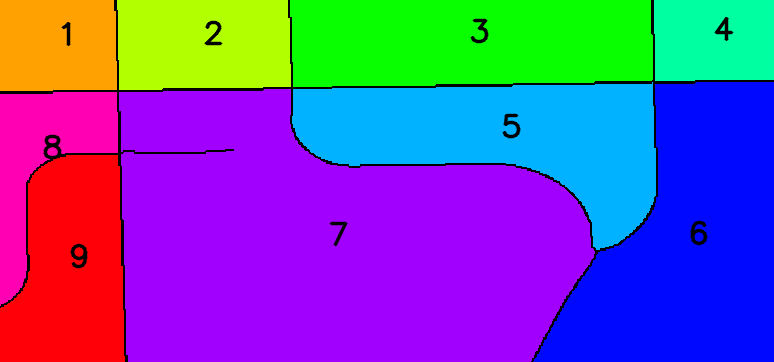

In [ ]:
image_path = r"/content/chicago_local_labeled.png"
text_coord_array = buildTextCoordinatesArray(centroids)
color = (1, 1, 1)
writeTextsOnImage(image_path, text_coord_array, color, False, '')

Now, we can deploy the algorithms on the entire Chicago region. Since Chicago has 154 region IDs, it will be too tedious to do a visual verification of the results. Therefore, we create a function that returns the connected region IDs, given a region ID.

In [ ]:
def returnConnectedRegionIDsFor(regionID, graphMatrix):
  n = graphMatrix.shape[0]
  regionID = regionID - 1
  if regionID < 0 or regionID >= n:
    return []
  connectedRegionIDs = []
  i = 0
  while i < n:
    connected = graphMatrix[regionID][i]
    if connected == 1 and regionID != i:
      connectedRegionIDs.append(i+1)
    i = i + 1
  return connectedRegionIDs

We try the function on a region ID.

In [ ]:
connectedRegionIDs = returnConnectedRegionIDsFor(7, graph_matrix)
print(connectedRegionIDs)

[1, 2, 3, 5, 6, 8, 9]


# **Build Graph Network for Chicago Region**

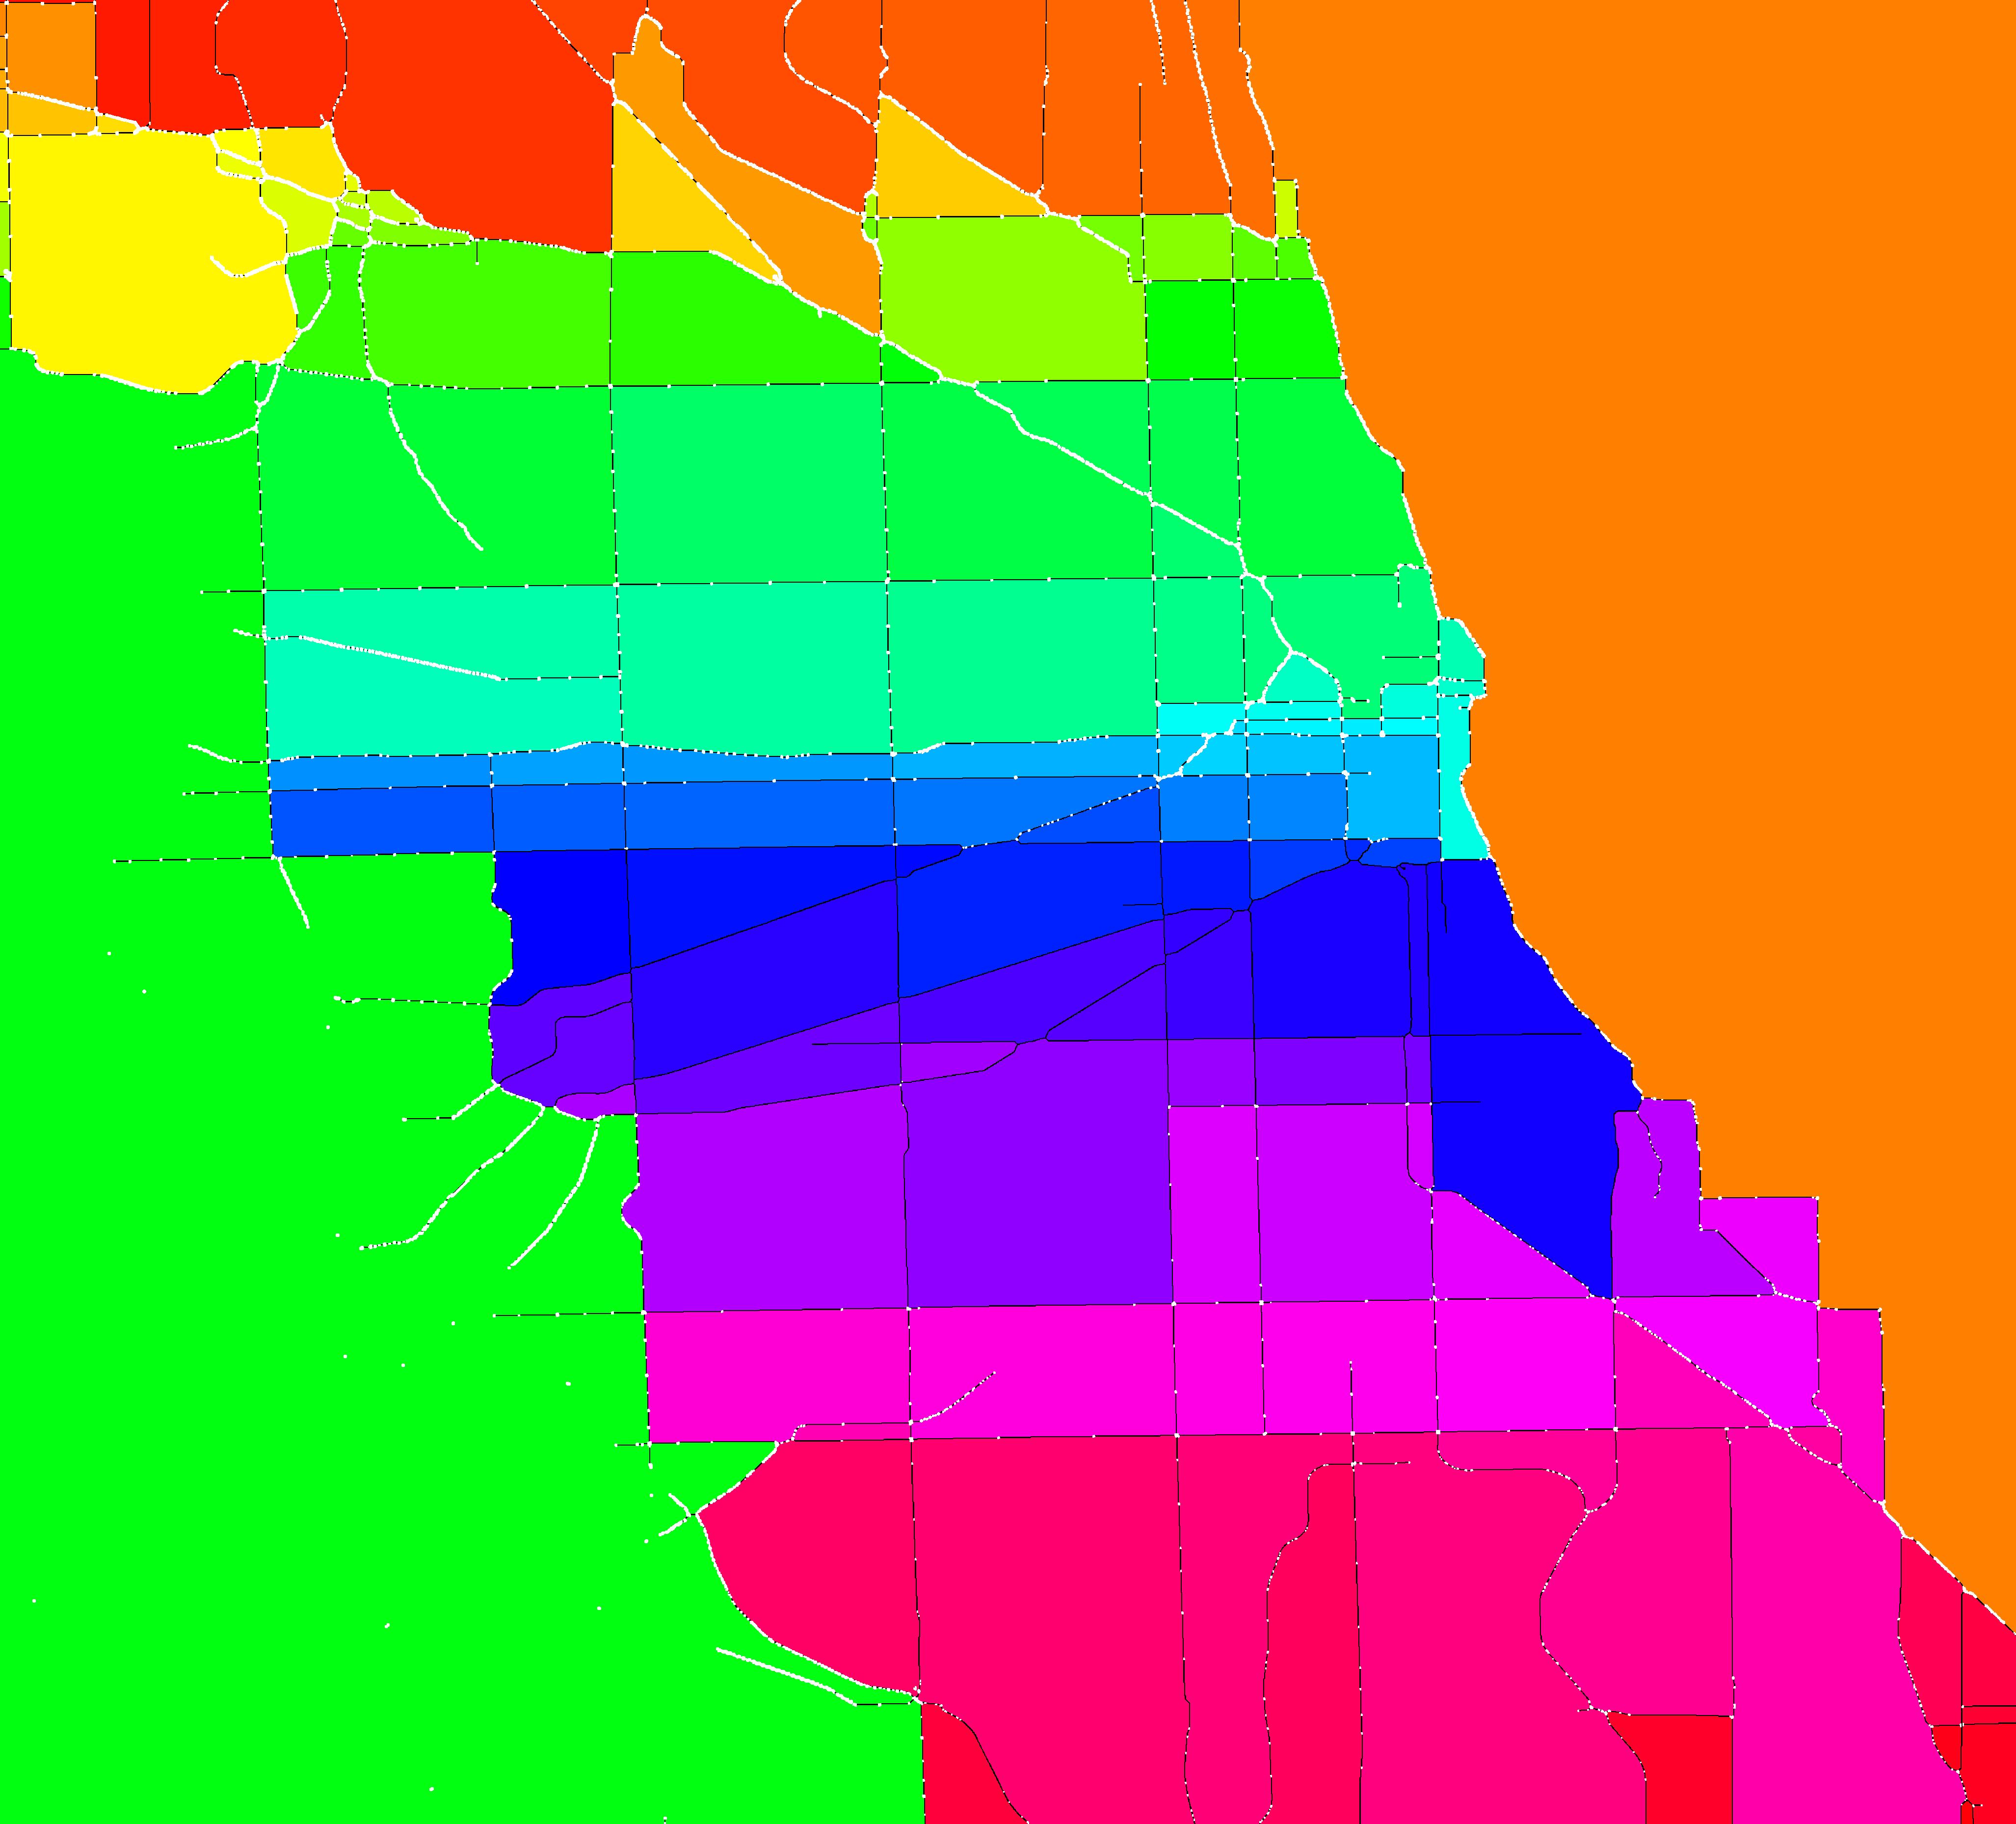

In [ ]:
filename = '/content/chicago_labeled.png'
img = cv2.imread(filename)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  #COLOR_BGR2GRAY

gray = np.float32(gray)
dst = cv2.cornerHarris(gray,4,3,0.03)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst,None)

# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[255,255,255]
cv2_imshow(img)

Unfortunately, the algorithm cornerHarris doesn't detect corners on blue colors. So, we take the binary version of the image below. The algorithm detects all the corners in this case.

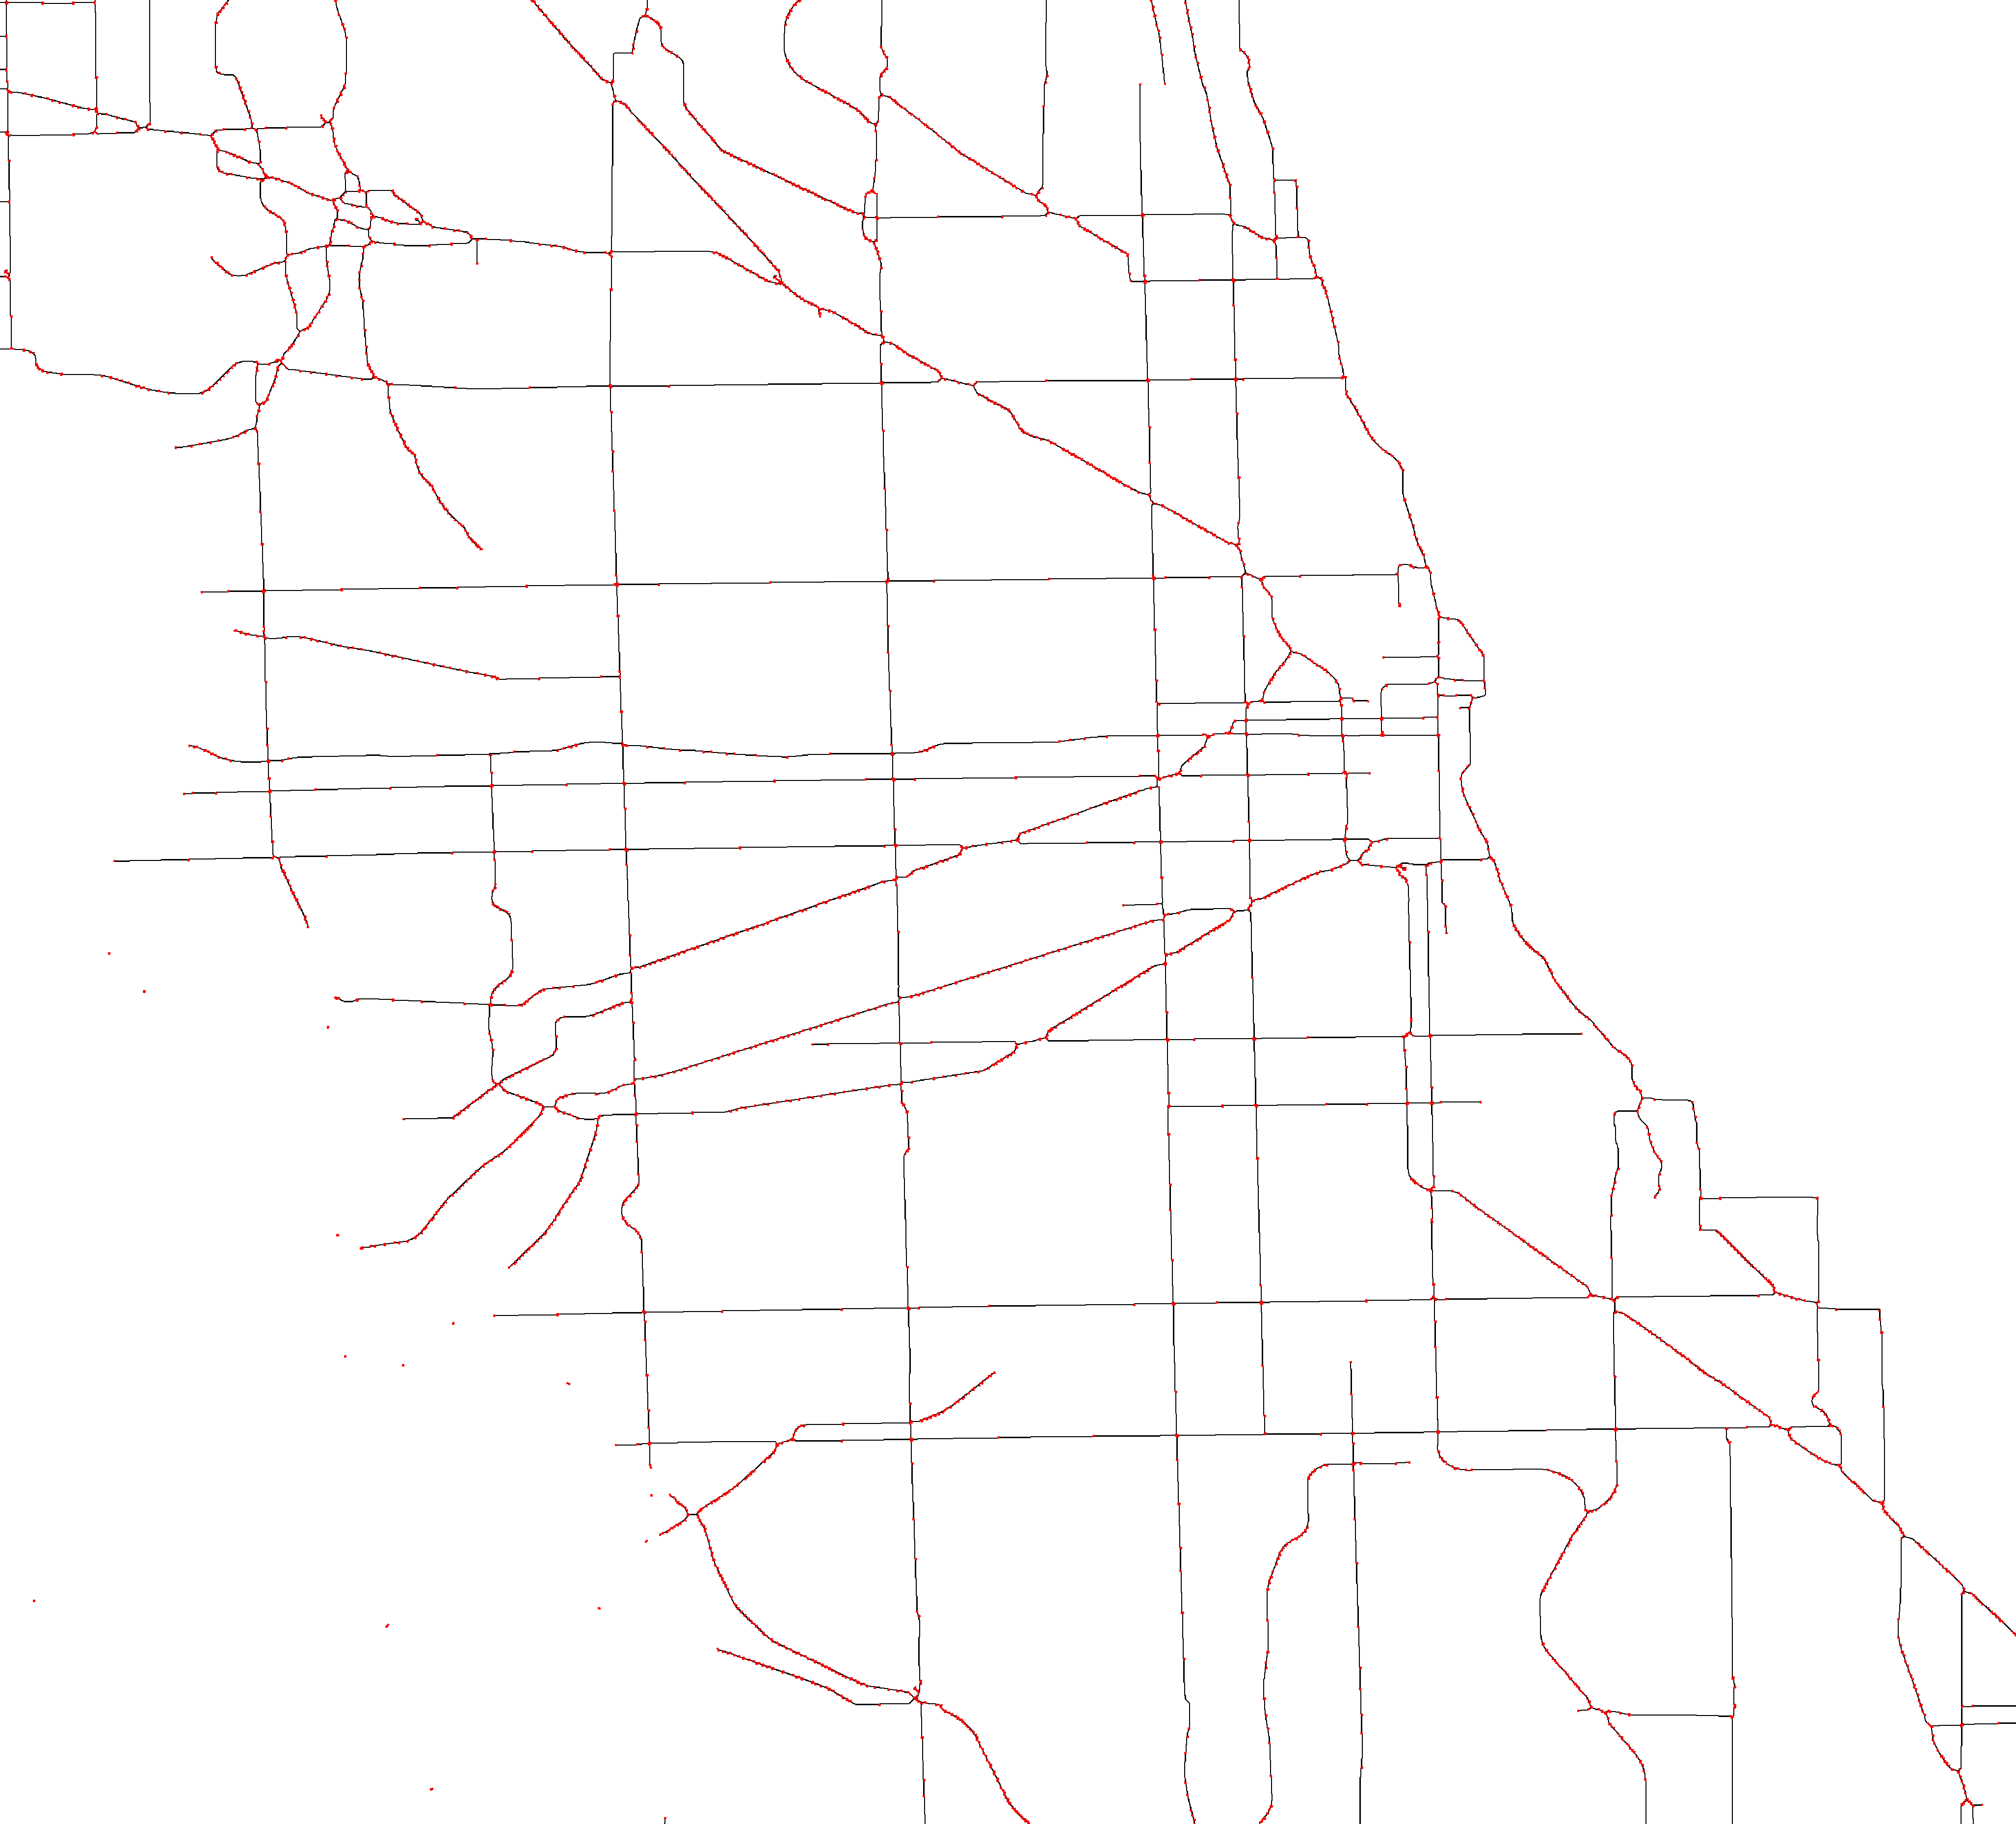

In [ ]:
filename = '/content/chicago_road_network_thinned_inverted_2.png'
imgbinary = cv2.imread(filename)
gray = cv2.cvtColor(imgbinary,cv2.COLOR_BGR2GRAY)

gray = np.float32(gray)
dstbinary = cv2.cornerHarris(gray,2,3,0.05)

#result is dilated for marking the corners, not important
dstbinary = cv2.dilate(dstbinary,None)

# Threshold for an optimal value, it may vary depending on the image.
imgbinary[dstbinary>0.05*dstbinary.max()]=[0,0,255]
cv2_imshow( imgbinary)

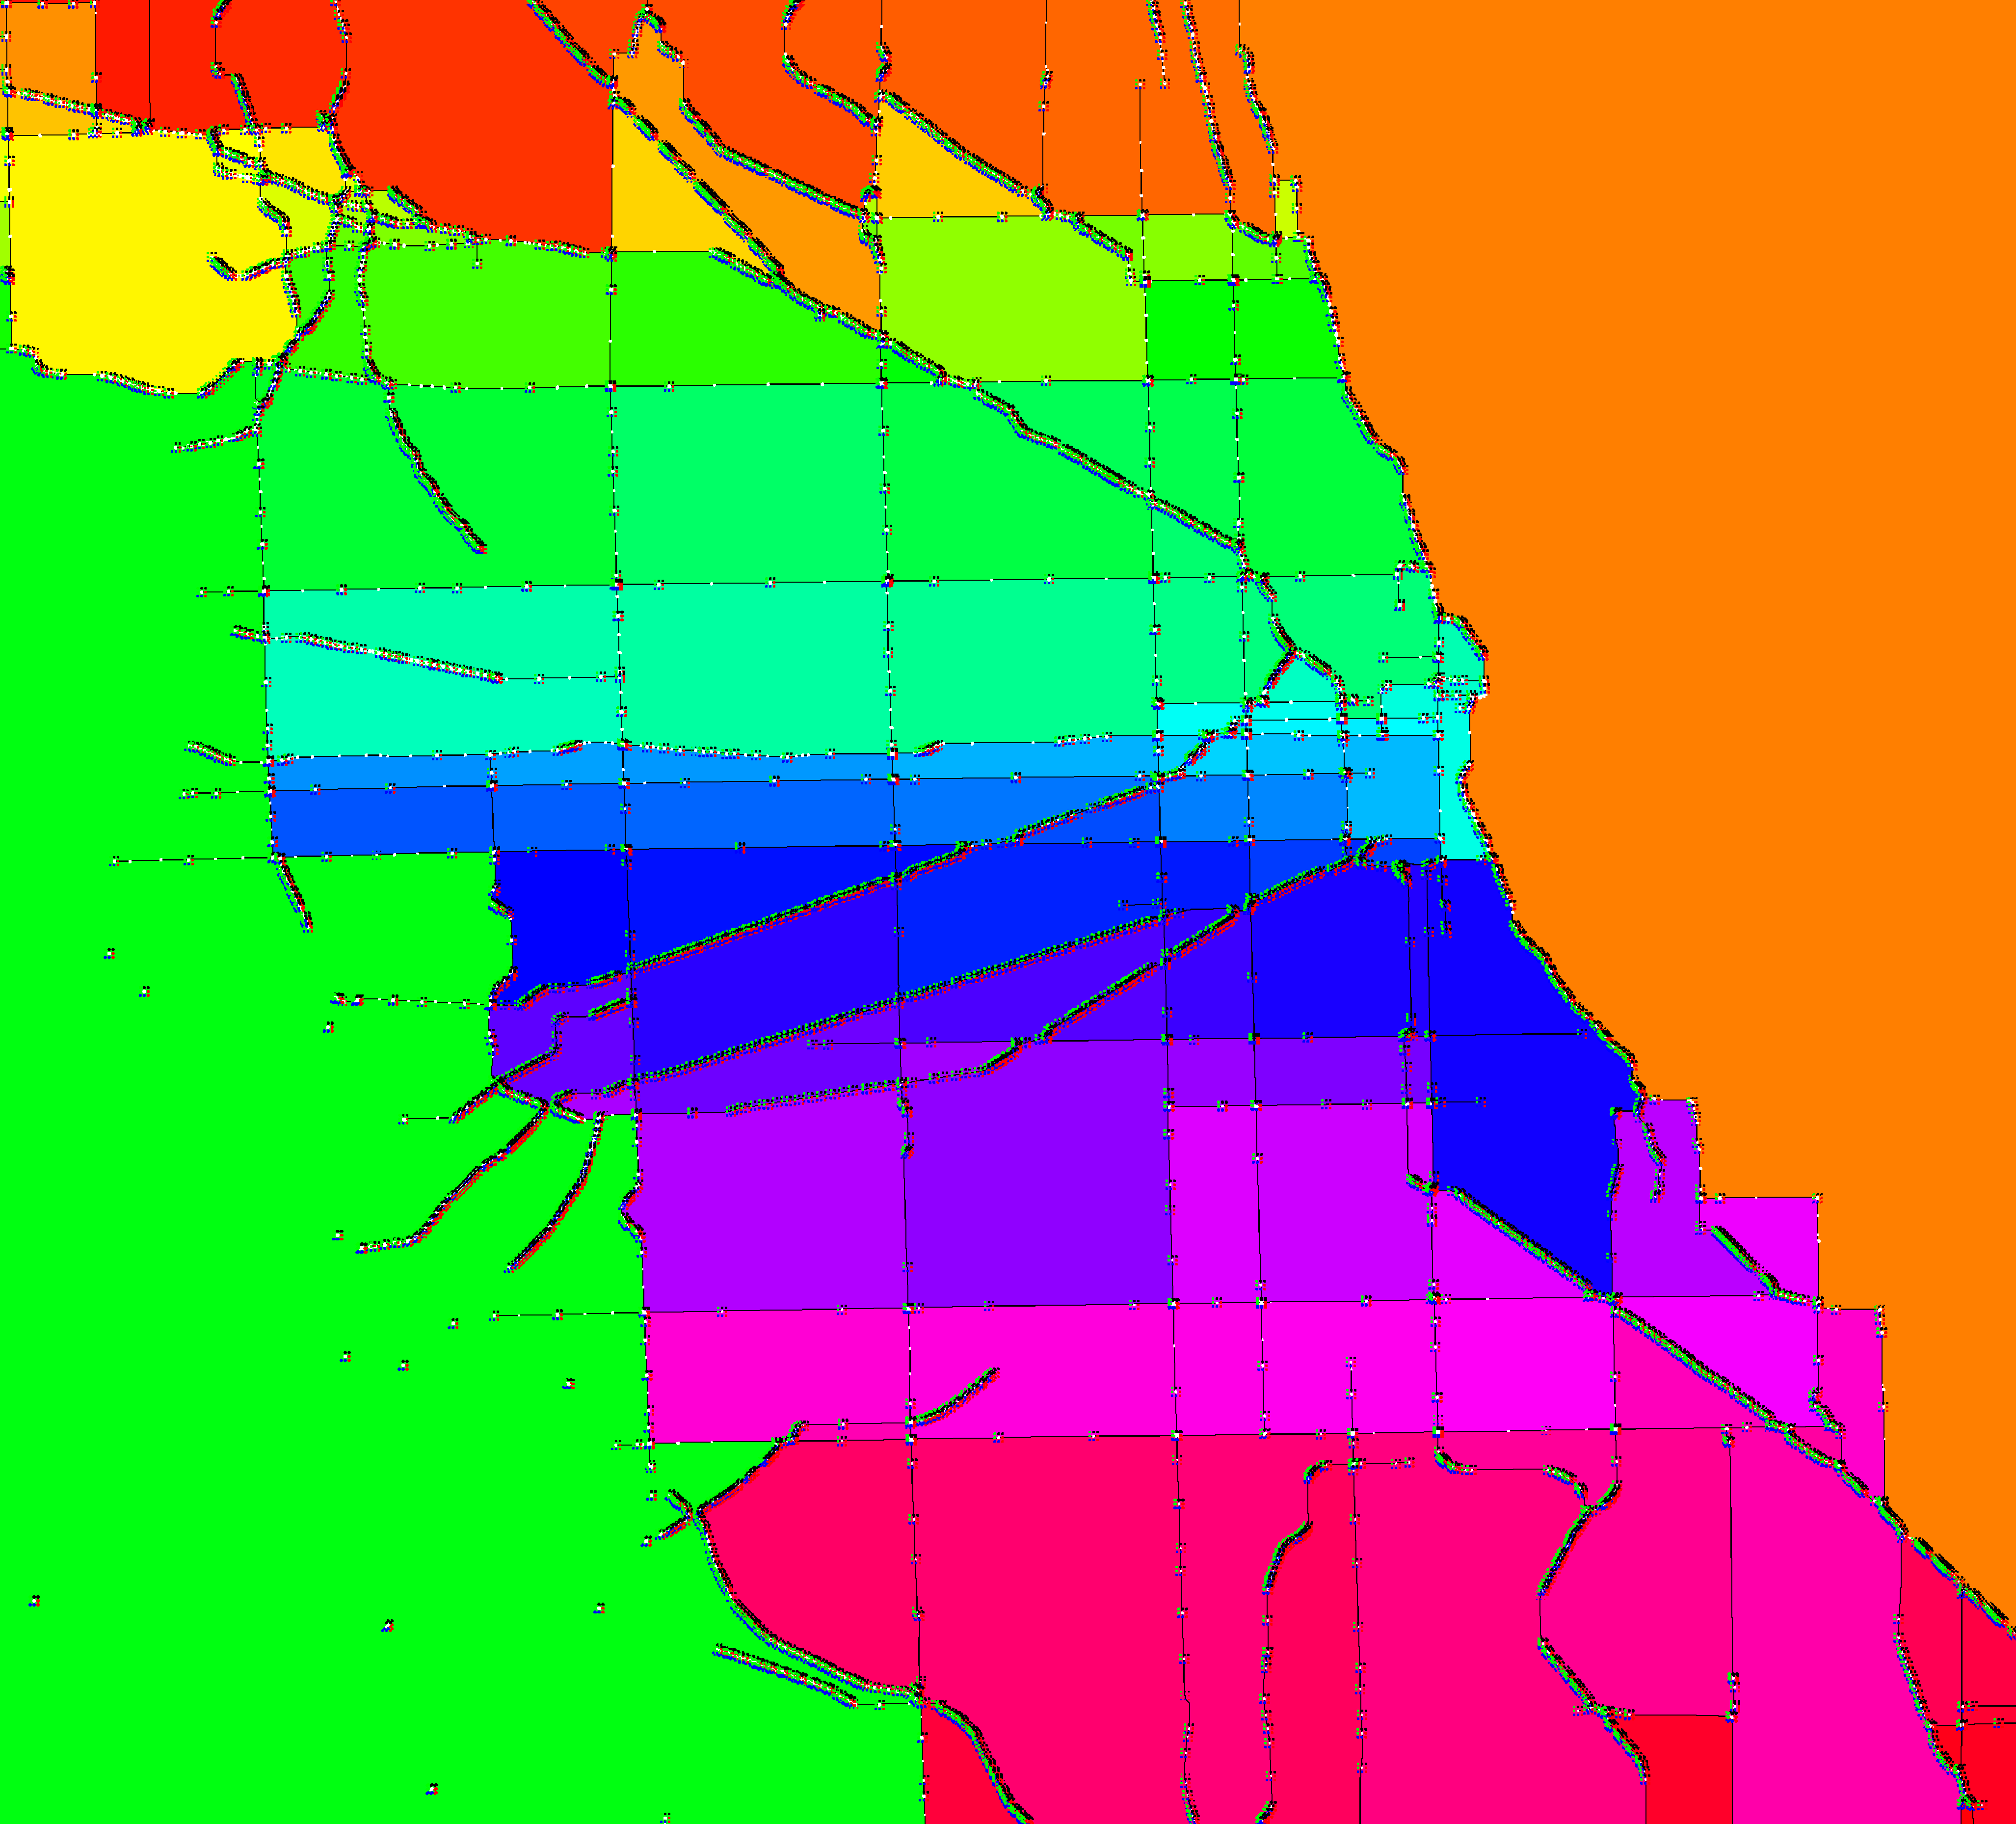

In [ ]:
corners_coord = return_corners_coord(dstbinary, 0.05)

baseImageCopy = img.copy()
mark_local_range(corners_coord, baseImageCopy)

cv2.imwrite('chicago_with_corners.png',baseImageCopy)

Now, all the regions are marked correctly with corners, we can build the graph matrix.

In [ ]:
graph_matrix = return_graph_matrix(labels_im, corners_coord)

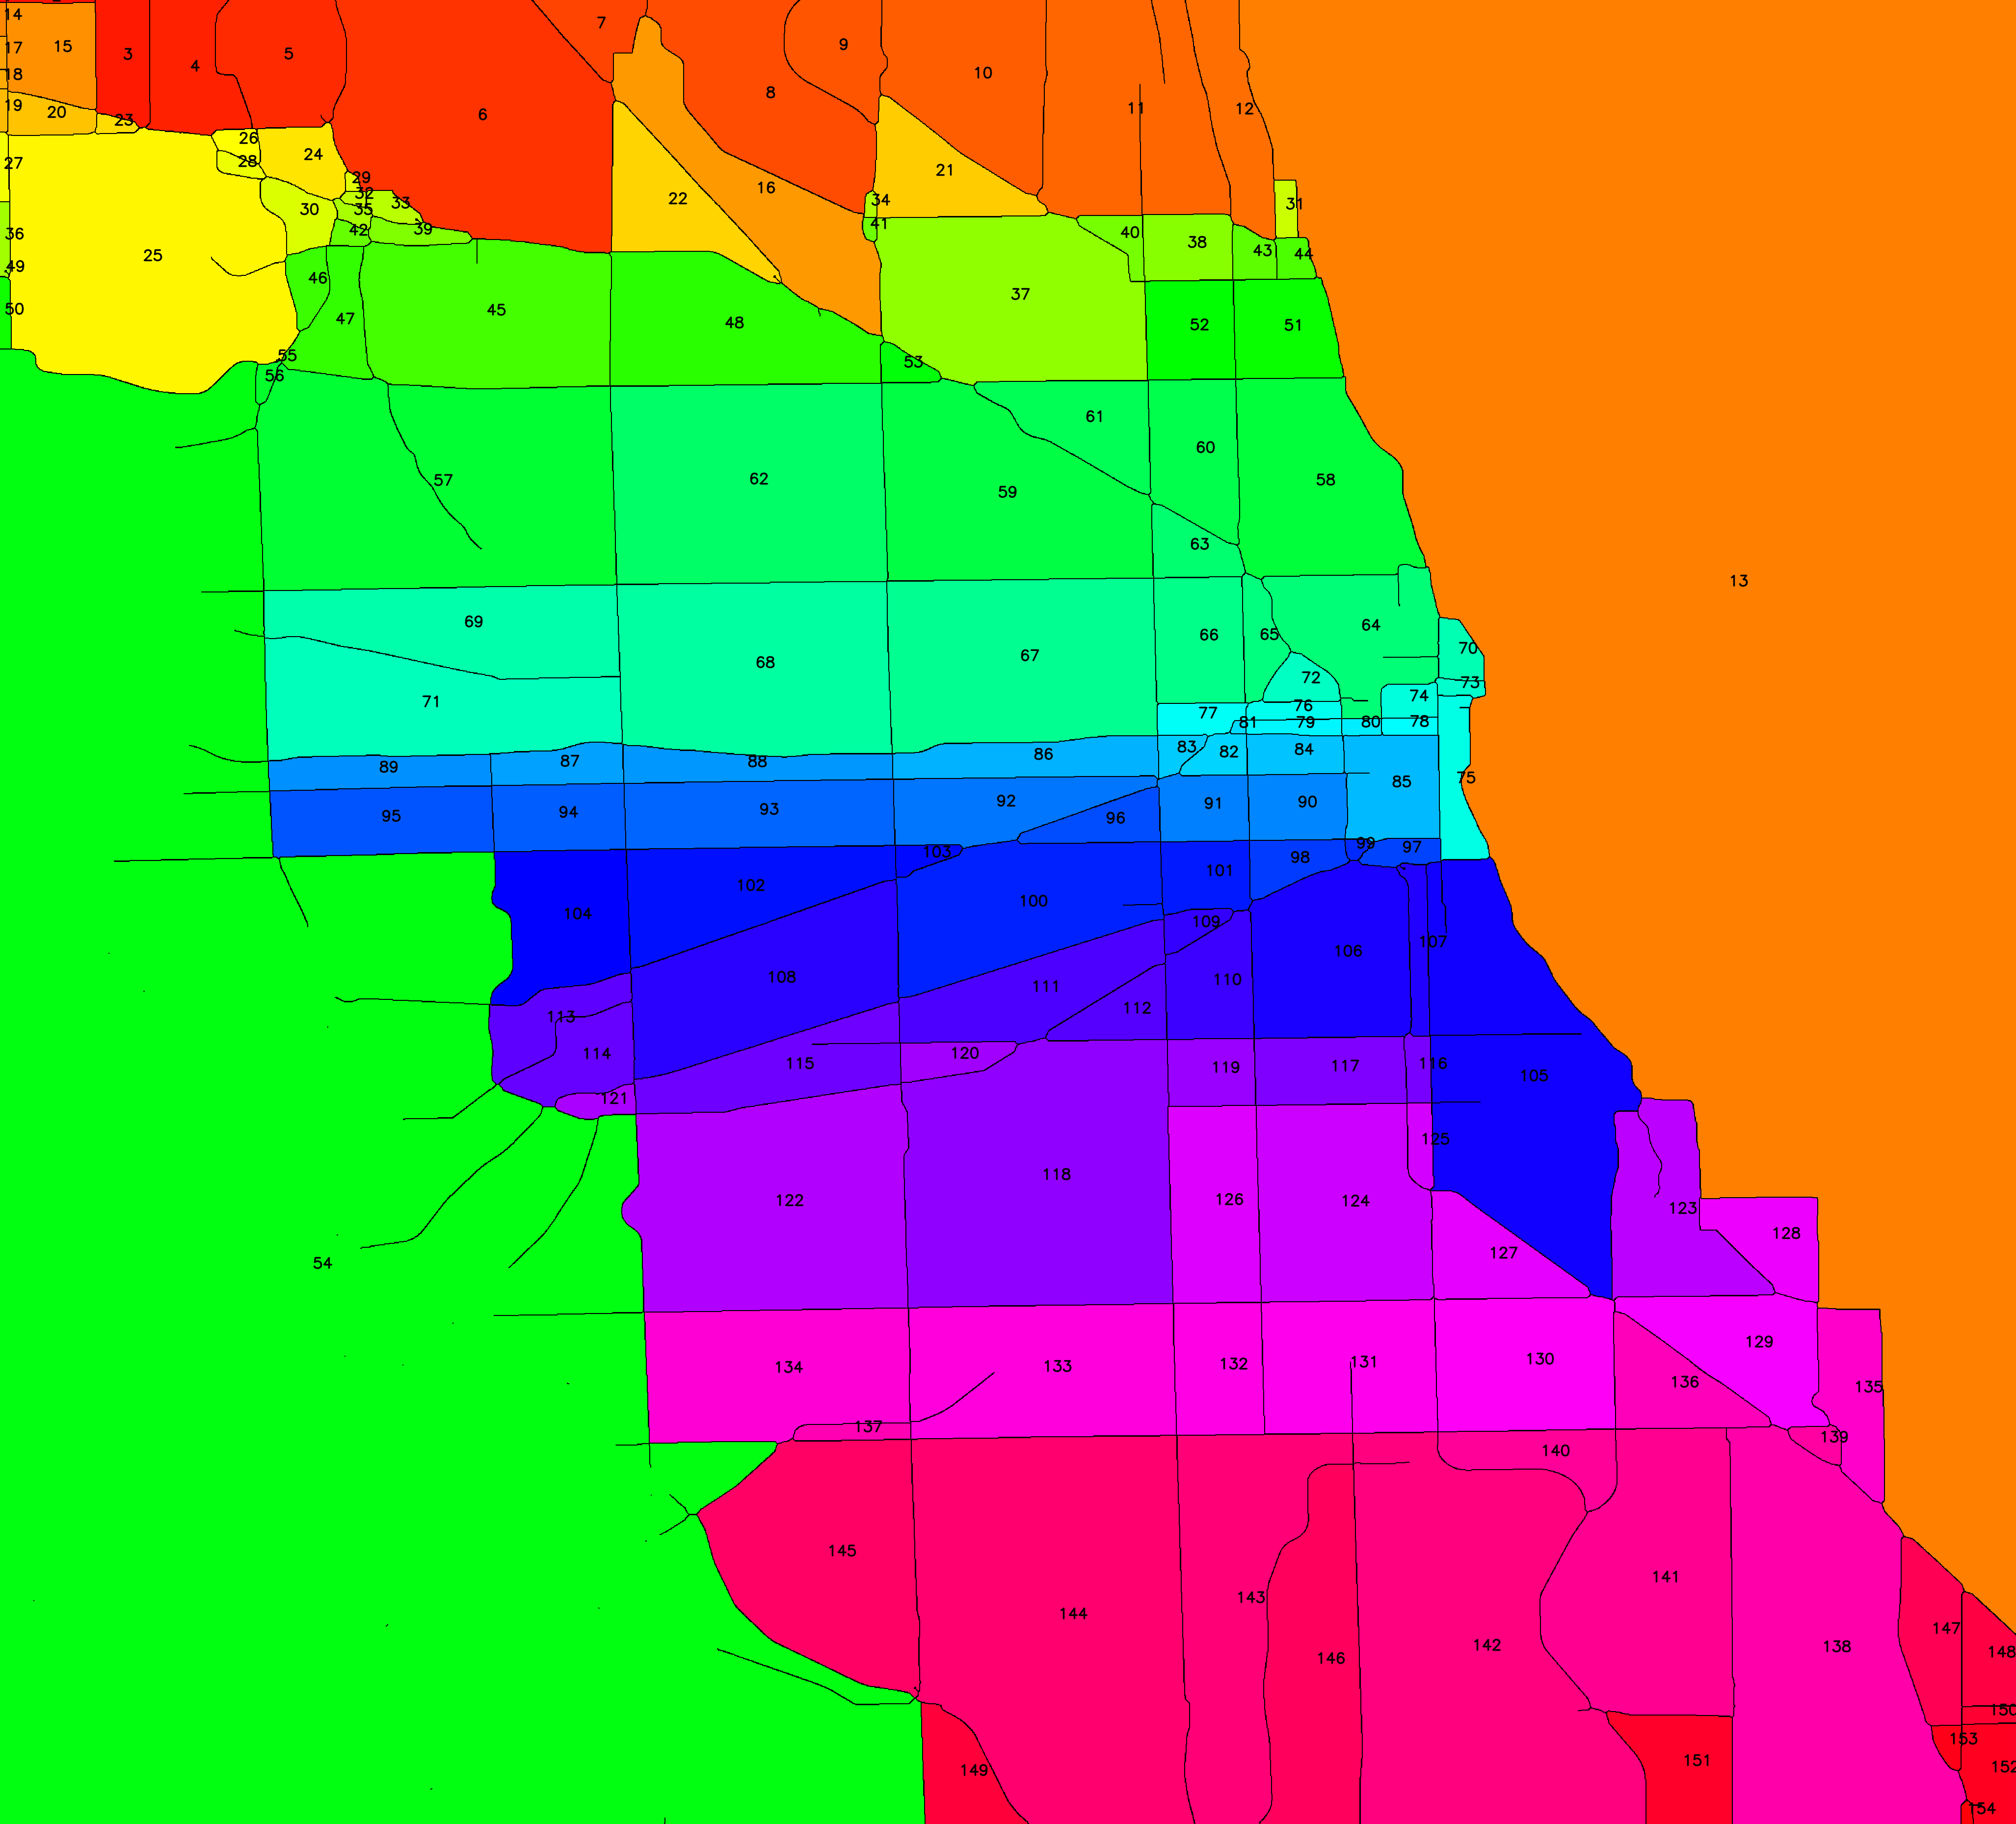

In [ ]:
image_path = r"/content/chicago_labeled.png"
text_coord_array = buildTextCoordinatesArray(centroids)
color = (1, 1, 1)
writeTextsOnImage(image_path, text_coord_array, color, False, '')

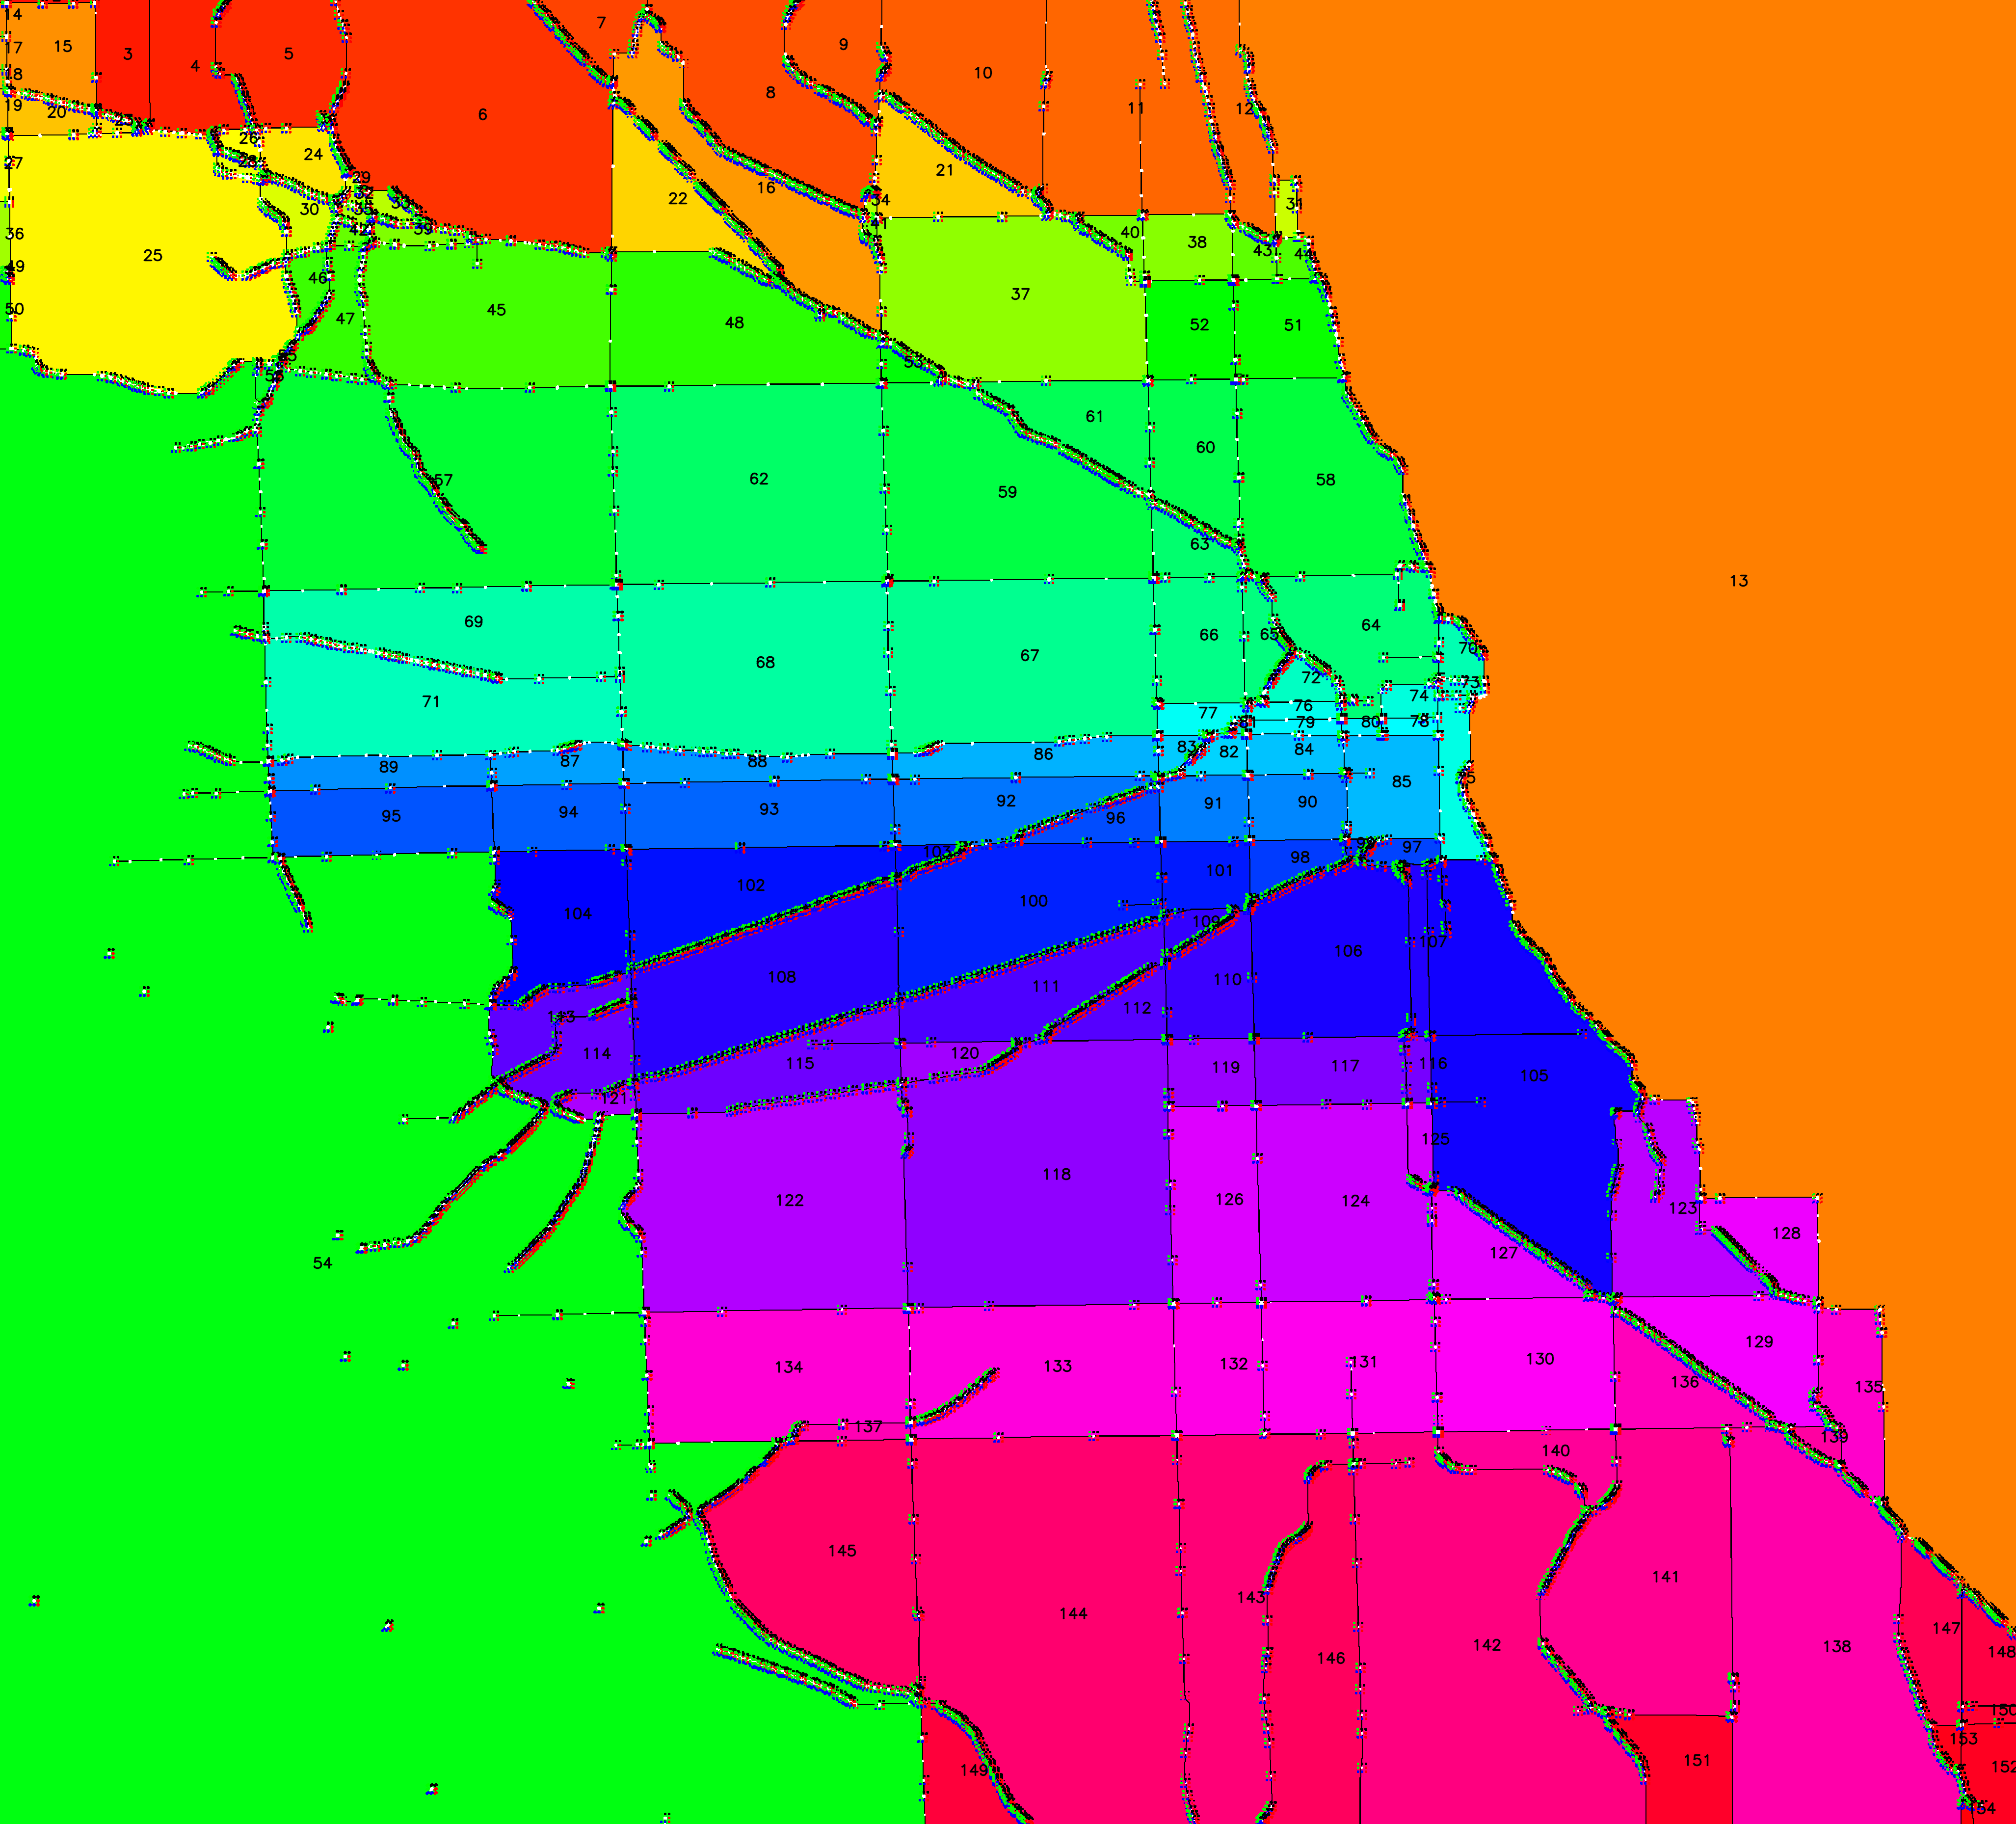

In [ ]:
image_path = r"/content/chicago_with_corners.png"
text_coord_array = buildTextCoordinatesArray(centroids)
color = (1, 1, 1)
writeTextsOnImage(image_path, text_coord_array, color, False, '')

We try with region ID 118 and compare the results between the graph matrix and the image above.

In [ ]:
connectedRegionIDs = returnConnectedRegionIDsFor(118, graph_matrix)

print(connectedRegionIDs)

[110, 111, 112, 115, 119, 120, 122, 126, 132, 133, 134]


In [ ]:
connectedRegionIDs = returnConnectedRegionIDsFor(41, graph_matrix)

print(connectedRegionIDs)

[8, 16, 21, 34, 37]


# **Conclusion**

Trying for different region IDs, we get all the correct conections. The graph network is ready for next step: clustering of the regions according to historic taxi trips.


Below, we just save the current work for future steps.

In [ ]:
#We save the labels, centroids and graph matrices for next steps 
from numpy import asarray
from numpy import savetxt
# define data
data = asarray( graph_matrix )
# save to csv file
savetxt('graph_matrix.csv', data, delimiter=',')

data = asarray( labels_im )
# save to csv file
savetxt('labels_im.csv', data, delimiter=',')

data = asarray( centroids )
# save to csv file
savetxt('centroids.csv', data, delimiter=',')

In [ ]:
from numpy import loadtxt
# load array
data = loadtxt('graph_matrix.csv', delimiter=',')
# print the array
connectedRegionIDs = returnConnectedRegionIDsFor(41, data)

print(connectedRegionIDs)

[8, 16, 21, 34, 37]


In [ ]:
!cp  '/content/centroids.csv' '/content/gdrive/My Drive/urban-computing-project/centroids.csv'

!cp  '/content/graph_matrix.csv' '/content/gdrive/My Drive/urban-computing-project/graph_matrix.csv'

!cp  '/content/labels_im.csv' '/content/gdrive/My Drive/urban-computing-project/labels_im.csv'

# **Sources**

1. cv2: https://pypi.org/project/opencv-python/